In [1]:
import tensorflow as tf
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import roc_curve, auc, multilabel_confusion_matrix
import re
import gc
import os
import glob
import keras
import pandas as pd
import numpy  as np
import itertools
from sklearn.metrics import confusion_matrix
from collections import Counter
import keras.backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense,Dropout, Input, Lambda, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.model_selection   import train_test_split
from keras.preprocessing.image import ImageDataGenerator

In [2]:
batch_size = 64
epochs = 20
pic_size = 48
np.random.seed(42)
tf.random.set_seed(42)

In [61]:
folder_path="C:/Users/Khalil/Downloads/images/images/images/"

In [62]:
def walk_data(mydict, folder_path):
    for (root,dirs,files) in os.walk(folder_path, topdown=False):
        if len(files)>0:
            mydict[root]=len(files)

In [63]:
train_dict = dict()
val_dict = dict()
walk_data(train_dict, folder_path + "train/")
walk_data(val_dict, folder_path + "validation/")

In [64]:
def fix_keys(mydict):
    new_dict = dict()
    for k, v in mydict.items():
        new_k = k.split('/')[-1]
        new_dict[new_k] = v
    return new_dict

In [65]:
train_dict = fix_keys(train_dict)
val_dict = fix_keys(val_dict)
print(train_dict)
print(val_dict)

{'angry': 3799, 'disgust': 435, 'fear': 4021, 'happy': 6299, 'neutral': 4947, 'sad': 4957, 'surprise': 3200}
{'angry': 876, 'disgust': 109, 'fear': 980, 'happy': 1668, 'neutral': 1196, 'sad': 1098, 'surprise': 787}


In [66]:
def plot_dist(my_dict, data):
    fig = px.bar(x=my_dict.values(),
             y=my_dict.keys(),
             orientation='h',
             color=my_dict.values(),
             title=data + ' Distribution',
             opacity=0.8,
             color_discrete_sequence=px.colors.diverging.curl,
             template='plotly_dark'
            )
    fig.update_xaxes()
    fig.show()

In [67]:
plot_dist(train_dict, "Training data")

In [68]:
plot_dist(val_dict, "Validation data")

In [3]:
datagen_train  = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
datagen_val = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

In [4]:
train_set = datagen_train.flow_from_directory(r"C:\Users\HP\Documents\Machine project\images\images\train",
                                              target_size = (pic_size,pic_size),
                                              
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)


val_set = datagen_val.flow_from_directory(r"C:\Users\HP\Documents\Machine project\images\images\validation",
                                              target_size = (pic_size,pic_size),
                                              
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False)

counter = Counter(train_set.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}  

Found 27658 images belonging to 7 classes.
Found 6714 images belonging to 7 classes.


In [5]:
model = Sequential()
model.add(VGG16(input_shape=(pic_size, pic_size, 3), weights='imagenet', include_top=False))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(7,activation='softmax'))

58889256/58889256 [==============================] - 36s 1us/step


In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 14,980,935
Trainable params: 14,980,935
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 14,980,935
Trainable params: 14,980,935
Non-trainable params: 0
_________________________________________________________________


In [75]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [9]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True
                          )
checkpoint = ModelCheckpoint("./model.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')


callbacks_list = [early_stopping,checkpoint]

In [10]:
history = model.fit_generator(train_set, 
                    validation_data = val_set,
                    class_weight=class_weights,
                    epochs = epochs,
                    steps_per_epoch=train_set.n//train_set.batch_size,
                   validation_steps = val_set.n//val_set.batch_size,callbacks=callbacks_list)

C:\Users\HP\AppData\Local\Temp\ipykernel_7224\775208614.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_set,


Epoch 1/20
432/432 [==============================] - 1533s 4s/step - loss: 0.6457 - accuracy: 0.2839 - val_loss: 0.3286 - val_accuracy: 0.4285
Epoch 2/20
432/432 [==============================] - 1594s 4s/step - loss: 0.4984 - accuracy: 0.4587 - val_loss: 0.2761 - val_accuracy: 0.5316
Epoch 3/20
432/432 [==============================] - 34689s 80s/step - loss: 0.4356 - accuracy: 0.5323 - val_loss: 0.2553 - val_accuracy: 0.5832
Epoch 4/20
432/432 [==============================] - 2048s 5s/step - loss: 0.3812 - accuracy: 0.5899 - val_loss: 0.2427 - val_accuracy: 0.6122
Epoch 5/20
432/432 [==============================] - 1417s 3s/step - loss: 0.3327 - accuracy: 0.6410 - val_loss: 0.2591 - val_accuracy: 0.5850
Epoch 6/20
432/432 [==============================] - 1416s 3s/step - loss: 0.2908 - accuracy: 0.6919 - val_loss: 0.2341 - val_accuracy: 0.6313
Epoch 7/20
432/432 [==============================] - 1410s 3s/step - loss: 0.2438 - accuracy: 0.7440 - val_loss: 0.2562 - val_accurac

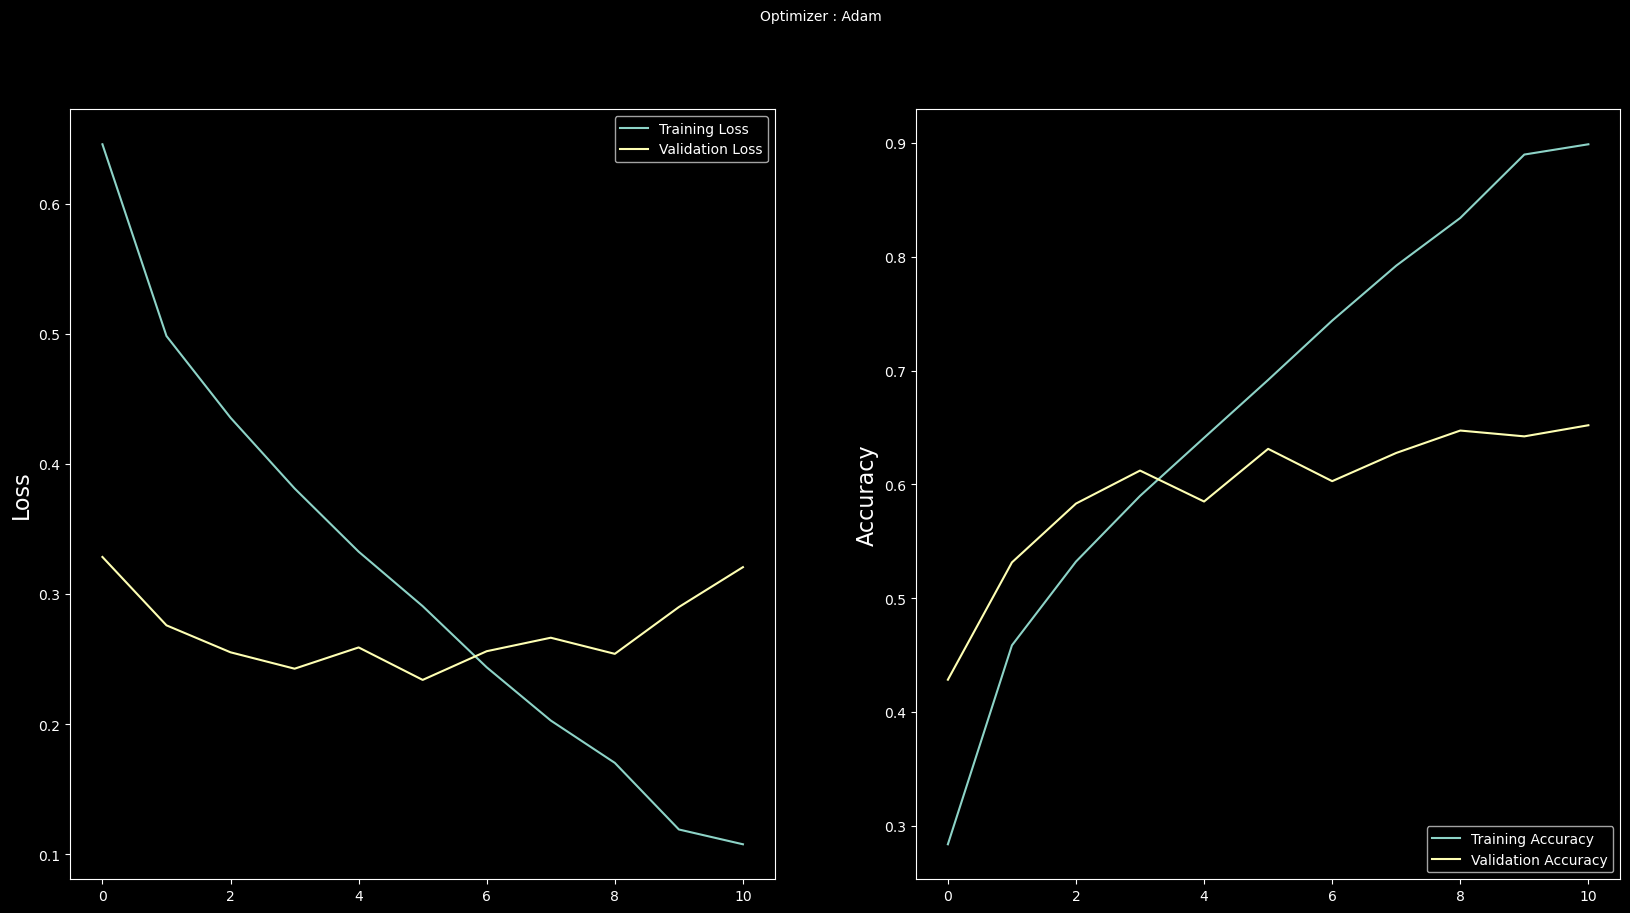

In [11]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_7224\227128211.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(generator=val_set)


<Figure size 640x480 with 0 Axes>

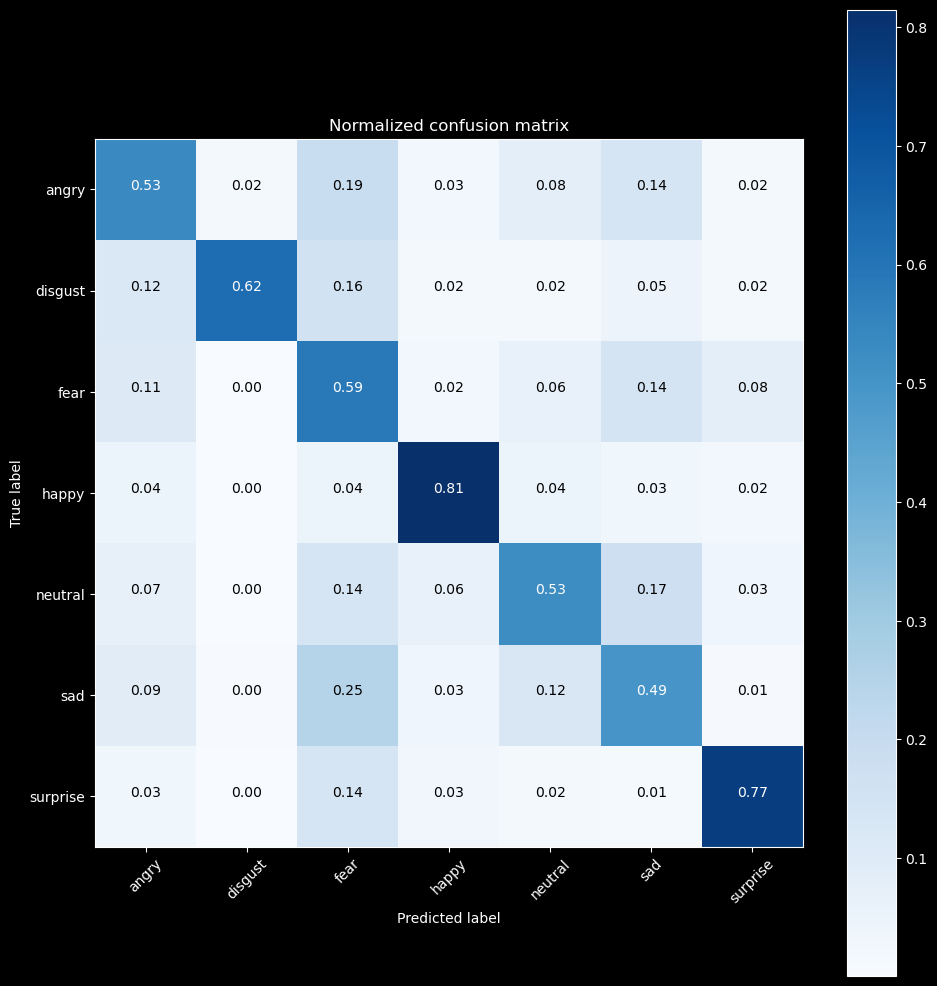

In [12]:
predictions = model.predict_generator(generator=val_set)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = val_set.classes
class_names = val_set.class_indices.keys()

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()